Regressão Polimonial



In [55]:
# pipenv install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi pydantic streamlit uvirocn requests

# EAD
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

# Model Trainning
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import zscore, shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

# Deploy Modul
import joblib

### 1. AED



#### Carga de Dados



Analisamos um arquivo CSV contendo informações sobre salários de mil funcionários de uma empresa, com três colunas: tempo na empresa (em meses), nível na empresa (de 1 a 10) e salário (em reais). Após importar as bibliotecas necessárias, inspecionamos o DataFrame, confirmando a ausência de valores ausentes e a correta identificação dos tipos de dados. Foram criadas cópias do DataFrame para realizar a análise exploratória e o bucketing, com base em agrupamentos numéricos. O próximo passo é o projeto prático de regressão polinomial.



In [56]:
# carregar dataset
df_salarios = pd.read_csv("./datasets/salario.csv")
df_salarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [57]:
# copiar DF para DF_EDA + DF_Bucketing
df_salarios_eda = df_salarios.copy()
df_salarios_bucketing = df_salarios.copy()

#### Medidas Estatísticas e Análise Gráfica BoxPlot



Iniciamos a análise exploratória dos dados verificando a ausência de valores ausentes no DataFrame. Extraímos medidas estatísticas para avaliar a estrutura dos dados: "tempo na empresa" varia de 1 a 120 meses, "nível na empresa" de 1 a 10, e "salário em reais" de R$ 538,56 a R$ 18.000. A média salarial é R$ 5.000, enquanto a mediana é R$ 3.237, indicando uma possível distribuição não normal. Usando boxplots, identificamos outliers na variável "salário em reais", mas optamos por mantê-los, pois foram validados pelo especialista do negócio. Esta foi uma análise inicial; a exploração continuará no próximo passo.



In [58]:
# listar primieiras linhas do DataFrame
df_salarios_eda.head(7)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35


In [59]:
# detectar valores ausentes - não há
df_salarios_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [60]:
# resumo de medidas estatísticas
df_salarios_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

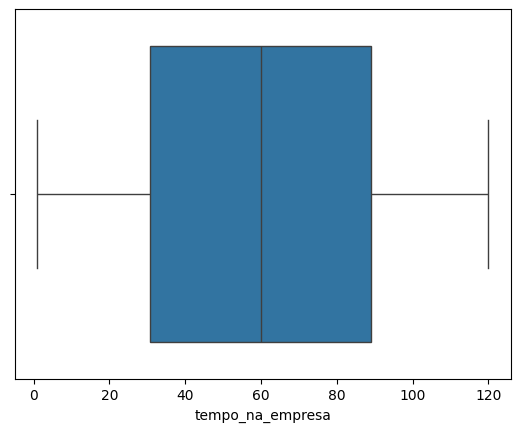

In [61]:
# verificar / detectar outliers - tempo na empresa
sns.boxplot(data=df_salarios_eda, x="tempo_na_empresa")

<Axes: xlabel='nivel_na_empresa'>

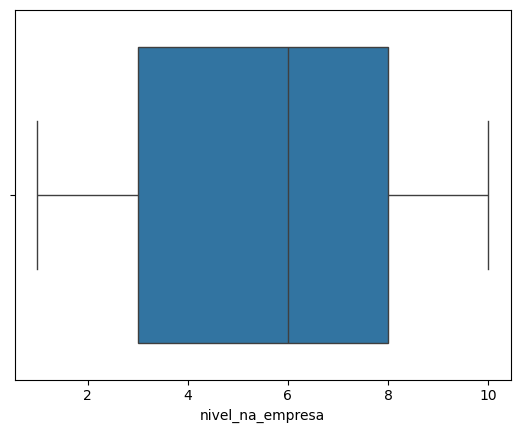

In [62]:
# verificar / detectar outliers - nível na empresa
sns.boxplot(data=df_salarios_eda, x="nivel_na_empresa")

<Axes: xlabel='salario_em_reais'>

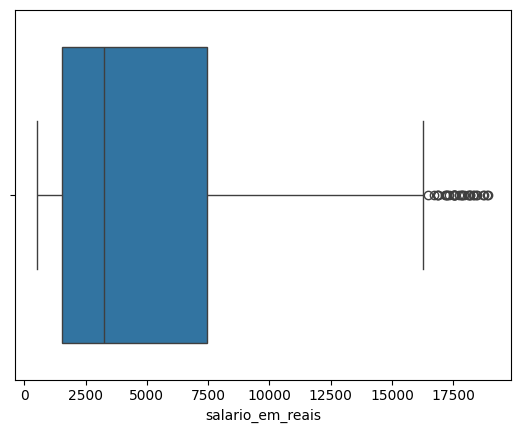

In [63]:
# verificar / detectar outliers - salário
sns.boxplot(data=df_salarios_eda, x="salario_em_reais")

#### Análise Gráfica Scatterplot e Histogramas



Prosseguimos com a análise exploratória, cruzando variáveis numéricas com "tempo na empresa" usando scatter plots. Identificamos que a relação entre "tempo na empresa" e "salário em reais" é curva, não linear, levando à introdução da regressão polinomial. A análise com "nível na empresa" mostrou ausência de padrões definidos tanto em relação ao "salário em reais" quanto ao "tempo na empresa". Utilizamos diagramas pair-plot para visualizar histogramas e confirmamos uma relação forte, porém não linear, entre "tempo na empresa" e "salário". Não foram identificadas correlações claras entre as demais variáveis. No próximo passo, exploraremos as correlações entre elas.


<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

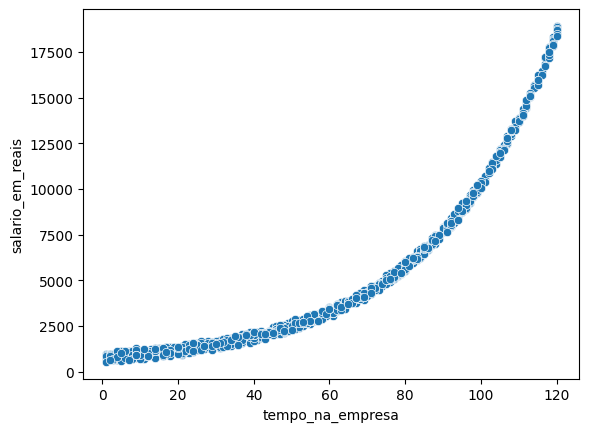

In [64]:
# cruzar variáveis numéricas com salário em reais (variável depensente)
sns.scatterplot(data=df_salarios_eda,
                x="tempo_na_empresa", y="salario_em_reais")

Podemos perceber que a relação entre "tempo na empresa" e "salário em reais" é curva, não linear, levando à introdução da regressão polinomial.

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

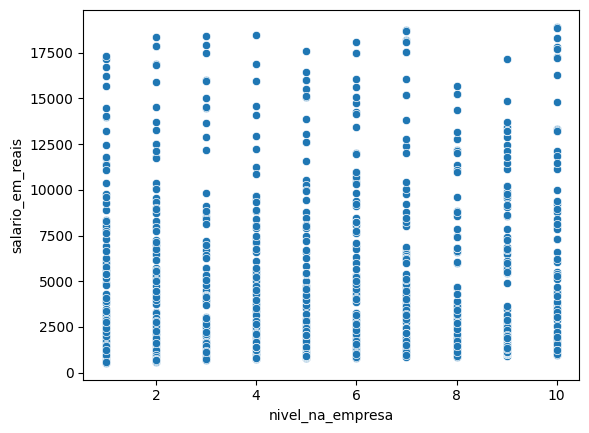

In [65]:
# cruzar variáveis numéricas com salário em reais (variável depensente)
sns.scatterplot(data=df_salarios_eda,
                x="nivel_na_empresa", y="salario_em_reais")

Podemos notar que o nível na empresa não interfere muito no salário do colaborador.

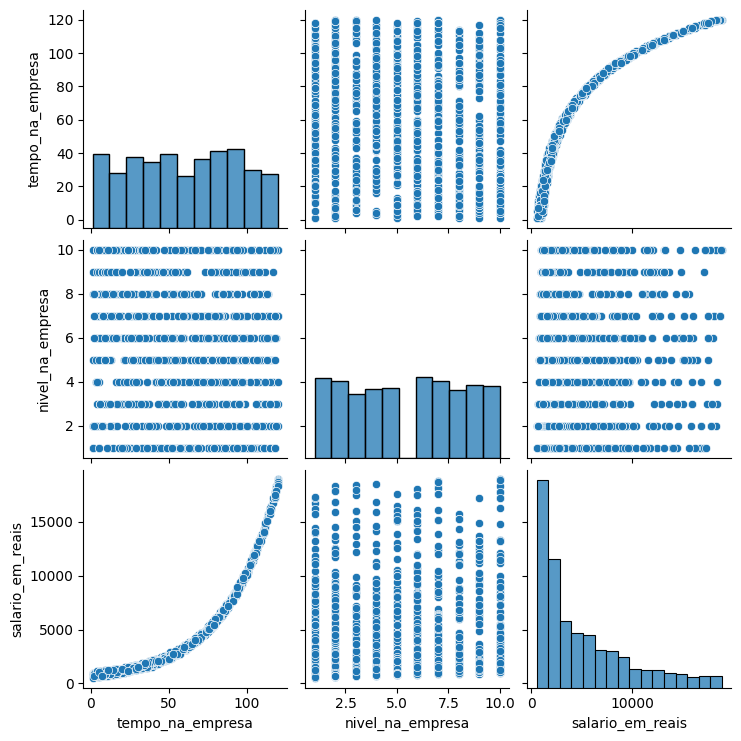

In [66]:
# histograma das variáveis
sns.pairplot(df_salarios_eda)

#### Análise de Correlação



Criamos um mapa de calor usando o método heatmap com correlação de Pearson. Identificamos que as correlações entre "nível na empresa" e "tempo na empresa" e entre "nível na empresa" e "salário em reais" são fracas, enquanto a correlação entre "tempo na empresa" e "salário em reais" é forte (0.91). Com a correlação de Spearman, que captura relações não lineares, essa última aumenta para 1, indicando uma correlação quase perfeita. Isso sugere uma relação não linear entre as variáveis. Também geramos um gráfico de ranking de correlações, destacando que "tempo na empresa" tem maior impacto no "salário em reais", enquanto "nível na empresa" apresenta correlação muito baixa.



<Axes: >

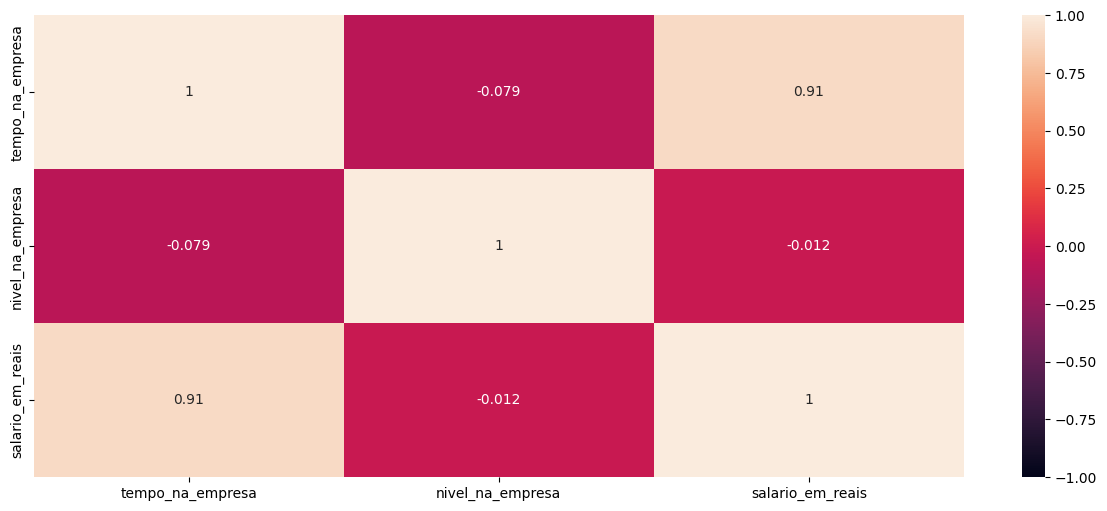

In [67]:
# exibir mapa de calor
plt.figure(figsize=(15, 6))
sns.heatmap(df_salarios_eda.corr(), vmin=-1, vmax=1, annot=True)

Podemos ver que a correlação de Pearson, que captura relações lineares (NÃO é o caso desse modelo), mostra uma correlação quase que perfeita. Então, como o modelo é não linear, a correlação de Spearman é mais adequada.

<Axes: >

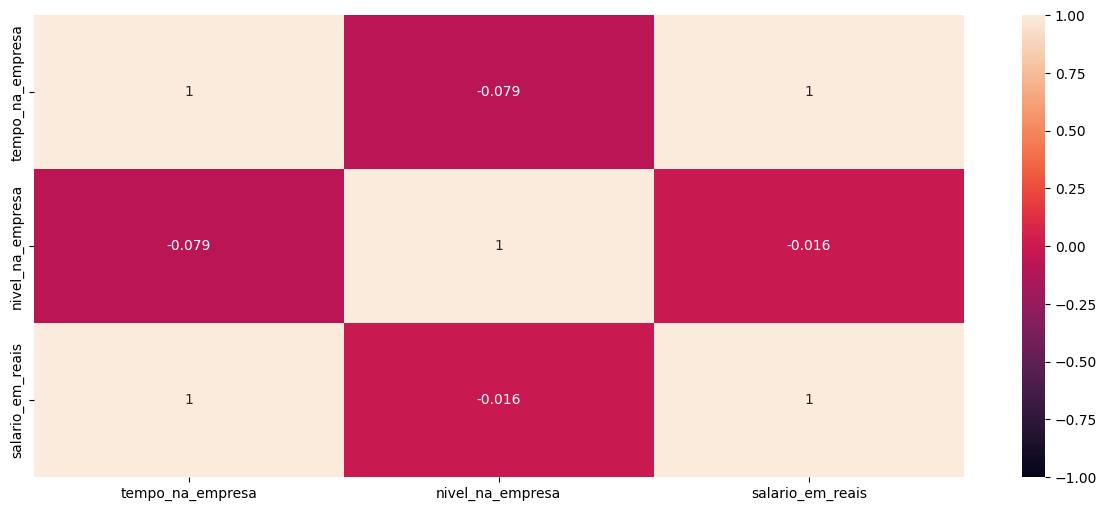

In [68]:
# exibir mapa de calor
plt.figure(figsize=(15, 6))
sns.heatmap(df_salarios_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

Podemos ver que a correlação Spearman, que captura relações não lineares (o caso desse modelo), mostra uma correlação quase que perfeita.

<Axes: >

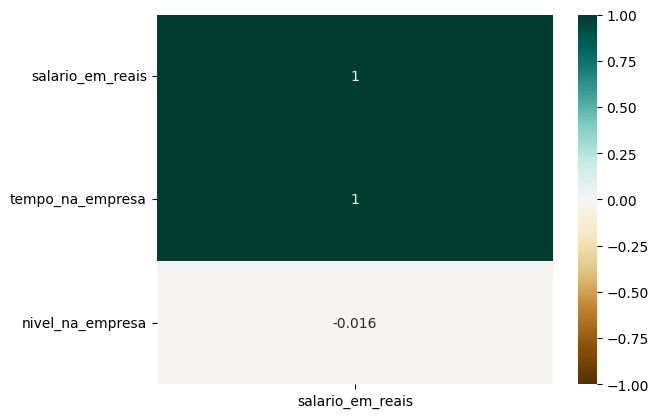

In [69]:
sns.heatmap(
    df_salarios_eda.corr("spearman")[["salario_em_reais"]].sort_values(
        by="salario_em_reais", ascending=False
    ),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="BrBG",
)

#### Análise Gráfica - Bucketing



Concluímos a análise exploratória utilizando o método de bucketing com a variável "tempo de casa". Os dados foram agrupados em faixas de 10 anos, de 0 a 120, usando a função cut do pandas. Em seguida, criamos um boxplot para analisar a relação entre "tempo de casa" e "salário", confirmando uma tendência de aumento salarial com o tempo, porém sem uma relação linear. A análise exploratória está finalizada e, a partir dos próximos passos, iniciaremos o treinamento e validação do modelo.



In [70]:
# bucketingt tempo de casa
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-89",
    "90-99",
    "100-109",
    "110-119",
    "120-129",
]
df_salarios_bucketing["escala_tempo"] = pd.cut(
    df_salarios_bucketing["tempo_na_empresa"],
    bins=bins_tempo_casa,
    labels=labels_tempo_casa,
    include_lowest=True,
)
df_salarios_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

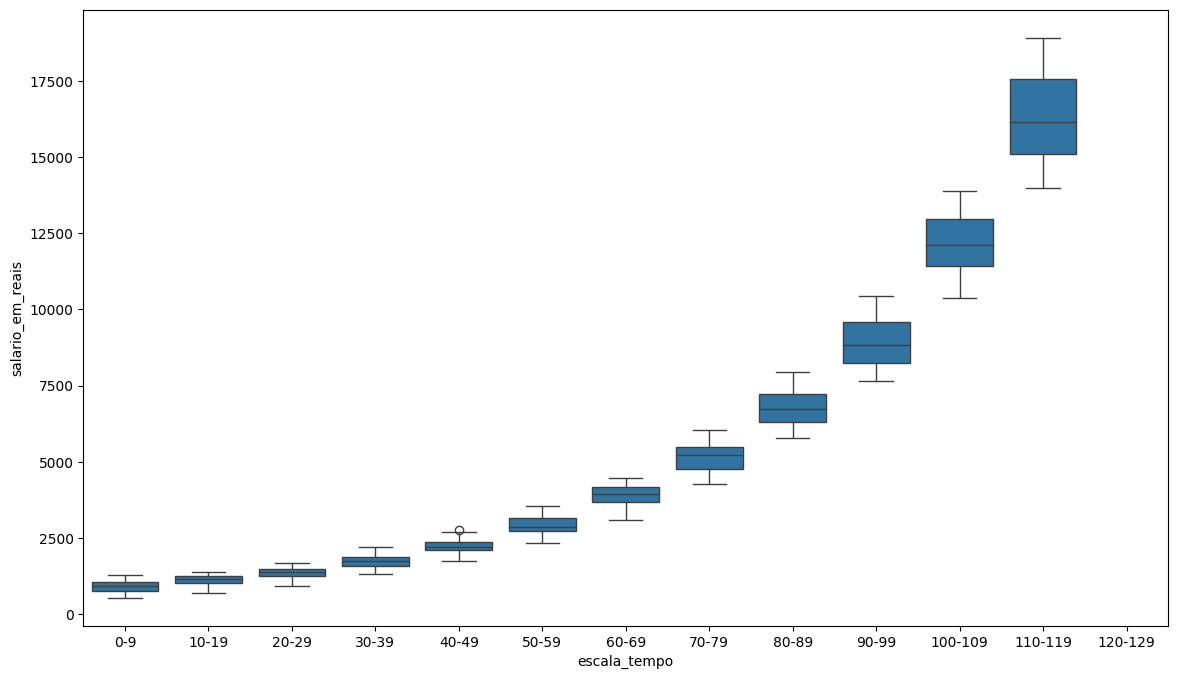

In [71]:
plt.figure(figsize=(14, 8))
sns.boxplot(df_salarios_bucketing, x="escala_tempo", y="salario_em_reais")

Podemos ver que quanto mais aumenta o tempo de casa, mais aumenta o salário. Vale ressaltar também que o gráfico não segue uma estrutura linear, mas sim parecido com uma curva.

### 2. Treinamento do Modelo - Regressão Linear



#### Divisão dos Dados com KFold (Para Validação Cruzada)



Exploramos a divisão de dados para treinamento usando validação cruzada em vez da abordagem tradicional. Os dados foram divididos em 5 partes, com 5 iterações onde 1 parte é usada para teste e as outras 4 para treino, permitindo coletar métricas e monitorar overfitting. Utilizamos o KFold com 5 splits para criar os conjuntos de treino e teste, após importar as bibliotecas necessárias.



In [72]:
# criar dataset de treino e de teste
X = df_salarios.drop(columns="salario_em_reais")
y = df_salarios["salario_em_reais"]

In [73]:
# split usando KFold com 5 pastas / splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)
kf

KFold(n_splits=5, random_state=51, shuffle=True)

Dividimos os dados em 5 partes (com 5 interações, com 1 parte sendo usadas para teste e as outras 4 para treino) || Shuffle serve para deixar aleatório.

Shuffle: Serve para embaralhar os dados antes de dividi-los em conjuntos de treino e teste. Isso pode ser útil porque, em muitos casos, os dados podem ter alguma ordem intrínseca, como temporal ou categórica. Sem o embaralhamento, é possível que os conjuntos de treino e teste fiquem enviesados.

#### Estrutura do Pipeline - Modelo de Regressão Linear



Nesta aula, vamos aprender a usar o Column Transformer para realizar transformações em colunas específicas de um conjunto de dados. Vamos criar um Column Transformer para aplicar uma transformação em colunas numéricas, utilizando o StandardScaler. Em seguida, vamos criar um Pipeline principal, que irá envolver o pré-processamento e o treinamento do modelo de regressão linear. Vamos utilizar o Column Transformer como pré-processador e o Linear Regression como modelo. Após isso, vamos partir para a parte de treinamento interativo, onde faremos ações em cima das K-folds. No próximo vídeo, continuaremos com o treinamento do modelo, utilizando um pipeline com a padronização das variáveis numéricas.



In [74]:
# Bloco para treinamento de modelo

# nomes da coluna
colunas_numericas = ["tempo_na_empresa", "nivel_na_empresa"]

# transformer para colunas numéricas
transformer_numericas = Pipeline(steps=[("scaler", StandardScaler())])

# criar uma ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[("num", transformer_numericas, colunas_numericas)]
)

# criar Pipeline principal = Pré-processamento + Treinamento
model_regr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
model_regr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tempo_na_empresa',
                                                   'nivel_na_empresa'])])),
                ('regressor', LinearRegression())])

#### Explicação sobre KFold e For Loop



Iniciamos o treinamento iterativo do modelo usando as divisões feitas com validação cruzada. As métricas de treino e teste foram armazenadas em uma lista para cálculo da média. Para detectar overfitting, comparamos os erros de treino e teste, observando se o erro no teste é significativamente maior, o que indicaria uma falta de generalização. Além disso, armazenamos as predições para análise dos resíduos. As iterações foram feitas usando o objeto KFolds para dividir os dados em treino e teste.



#### Construção do Loop de Treinamento - Regressão Linear



Foram discutidos conceitos relacionados ao overfitting e avaliadas métricas de desempenho do modelo. O overfitting foi identificado como o ajuste excessivo do modelo aos dados de treinamento, comprometendo sua capacidade de generalização. As métricas calculadas incluíram RMSE (Root Mean Squared Error) para os conjuntos de treinamento e teste, além do R², que mede a qualidade do ajuste. Também foram analisados os resíduos, que representam as diferenças entre os valores reais e as previsões. As métricas calculadas foram armazenadas para futuras análises, garantindo uma avaliação consistente do desempenho do modelo.



In [75]:
# armazenar RMSE treino e teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# armazenar R2 Score de teste
r2score_fold_test = []

# armazenar resíduos
residuos = []

# armazenar predições
y_pred_total = []

# iloc - seleciona dados utilizando índices inteiros baseados na posição
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # treinar o modelo no conjunto de treinamento
    model_regr.fit(X_train, y_train)

    # fazer predições nos conjuntos de treinamento e teste
    y_train_pred = model_regr.predict(X_train) # Aqui, pegamos o modelo que ele obteve do conjunto de treinamento e utilizamos ele mesmo para fazer predições do conjunto de treinamento. Caso o erro for bem alto, já no treinamento, podemos notar que o modelo sofreu underfititng, ou seja, nem com os próprios dados do treinamento ele conseguiu criar um padrão nem para os dados de treinamento. 
    y_test_pred = model_regr.predict(X_test)

    # Calcular o RMSE para os conjunstos de treinamento e teste
    rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
    rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5


    # Calcular o R2score e Residuos para conjunto de teste
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    # Armazenamando as métricas da iteração na lista
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = (
    (rmse_test_final - rmse_train_final) / rmse_train_final) * 100

# transformar em lista unidimensional
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### 3. Validação do Modelo - Regressão Linear



#### Análise de Métricas - Regressão Linear



Armazenamos os resíduos do modelo em uma lista e os transformamos em uma estrutura unidimensional usando reshape. O mesmo processo foi aplicado à lista y_pred_total. Em seguida, calculamos e analisamos as métricas de desempenho do modelo linear. O RMSE no conjunto de treinamento foi de R$1.862,00, enquanto no conjunto de teste foi de R$1.886,00, resultando em uma diferença percentual de apenas 0,2%. O R² no conjunto de teste foi 0,82, indicando um bom ajuste geral do modelo. A pequena diferença entre as métricas de treinamento e teste sugere que o modelo não apresenta problemas de overfitting. O próximo passo será uma análise detalhada dos resíduos.



In [76]:
# Métricas
print(f'RMSE Treino: R${rmse_train_final:.2f}')
print(f'RMSE Teste: R${rmse_train_final:.2f}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final:.4f}%')
print(f'R2Score Teste: {r2score_test_final:.4f}')

# ausencia de overfitting

RMSE Treino: R$1882.83
RMSE Teste: R$1882.83
% Dif. RMSE Treino e Teste: 0.1922%
R2Score Teste: 0.8261


#### Chegamos a conclusão com esses resultados que como a diferença em percentual entre eles é 4 reais, o que não podemos afirmar que houve um overfitting pois a diferença não é grande. 
#### Quanto ao R2Score ser 0,82 como temos a escala de 0 à 1, é um número grande, porém não é o ideal. Modelos mais ajustados estariam acima dos 0,90.

#### Portanto, chegamos a conclusão de que não há overfitting

#### Análise Gráfica de Resíduos - Regressão Linear



Realizamos a análise dos resíduos do modelo linear, transformando-os na escala padrão com o pacote SciPy. Essa transformação permitiu verificar a linearidade, com resíduos idealmente entre -2 e 2 na escala padronizada, e avaliar a homoscedasticidade, observando graficamente se os valores se distribuem de forma consistente em torno de uma reta. Em seguida, utilizamos o gráfico QQPlot para verificar a normalidade dos resíduos. Desvios significativos da reta de 45 graus indicaram possíveis violações de normalidade. Essas análises gráficas fornecem um ponto de partida para entender a qualidade do modelo. O próximo passo será validar essas observações por meio de testes estatísticos.


In [77]:
# transformar residuos em escala padrão
# (X - media) / desvio-padrão
residuos_std = zscore(residuos)
residuos_std

array([ 5.95616525e-01, -7.24916727e-01, -6.46846433e-01,  8.64095533e-01,
       -5.33806156e-02, -7.61704833e-01,  6.80947606e-01,  1.45661295e+00,
        3.15407488e-01, -5.85616590e-01,  1.29483240e-01,  8.62850152e-01,
       -8.81408422e-01, -2.57676835e-01, -3.98447700e-01,  4.84215194e-01,
       -9.30147928e-01, -1.98427398e-01,  2.09007896e-01, -9.04965560e-01,
       -6.81287606e-02, -8.34446292e-01, -3.95656924e-01,  1.85180868e-01,
       -8.59767063e-01, -1.16014546e+00, -9.89137623e-01,  1.98282340e+00,
       -7.09136535e-01, -5.86755306e-01,  2.97904569e+00,  3.41834809e-01,
       -1.07716414e+00,  1.30248304e+00, -5.99662310e-01, -4.35883427e-01,
       -5.78726106e-01, -1.02611646e+00,  3.62850210e-01,  1.01353539e+00,
       -3.51902591e-01,  9.50243614e-01,  1.10020428e+00,  3.93453210e-01,
       -8.28856918e-02, -2.86114598e-01, -1.14814701e+00, -7.64435745e-01,
       -2.96268121e-01, -9.37004031e-01, -5.80106334e-01,  4.60575328e-02,
       -2.64983022e-01,  

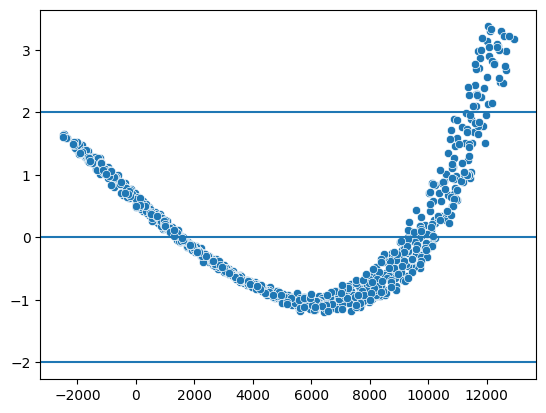

In [78]:
# verificar linearidade dos resíduos: valores entre -2 e +2 (escala padrão)
# verificar homocedasticidade: valores em torno da resta sem nenhuma tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

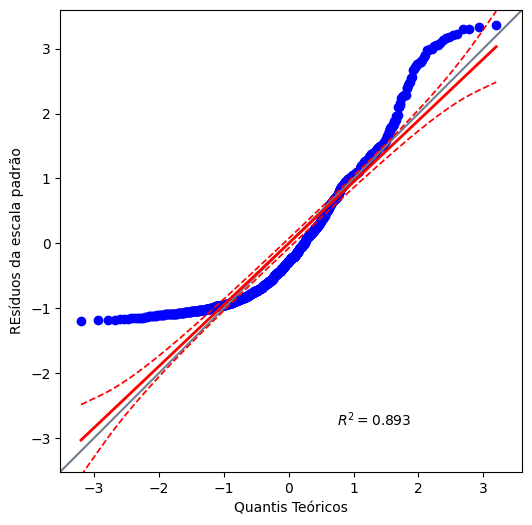

In [79]:
# checar se resíduos seguem um distribuição normal
# ## QQplot
plt.figure(figsize=(12,6))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel("Quantis Teóricos")
plt.ylabel("REsíduos da escala padrão")
plt.show()

#### Teste de Normalidade de Resíduos - Regressão Linear



Continuamos a análise de resíduos realizando testes estatísticos para verificar a normalidade, incluindo Shapiro-Wilk, Kolmogorov-Smirnov e Lilliefors. Os resultados apontaram que os resíduos não seguem uma distribuição normal, sugerindo limitações do modelo de regressão linear para os dados analisados. Essa conclusão abre a possibilidade de explorar modelos mais robustos ou complexos para melhor capturar as características do conjunto de dados. Em seguida, iremos avaliar a aplicação de um modelo polinomial como alternativa.



In [80]:
stat_shapiro, p_value_shapiro = shapiro(residuos)
print (f'Estat: teste = {stat_shapiro:.4f} e P-Value = {p_value_shapiro}')

Estat: teste = 0.8920 e P-Value = 7.013497918014399e-26


In [81]:
# Teste de normalidade
stats_ks, p_value_ks = kstest(residuos, "norm")
print(f"Estat: Teste = {stats_ks:.4f} e P-Value = {p_value_ks}")

Estat: Teste = 0.5940 e P-Value = 0.0


In [82]:
# Teste de Normalidade _ Lillefors
stat_ll, p_value_ll = lilliefors(residuos, dist="norm", pvalmethod="table")
print(f"Estat: Teste = {stat_ll:.4f} e P-Value = {p_value_ll}")

Estat: Teste = 0.1183 e P-Value = 0.0009999999999998899


### 4. Treinamento do Modelo - Regressão Polinomial



#### Features Polinomiais



Geramos features polinomiais para treinar um modelo de regressão linear, utilizando a classe PolynomialFeatures do scikit-learn. Esse processo cria novas combinações das features originais com base no grau especificado pelo parâmetro degree. Também configuramos o parâmetro include_bias para incluir ou excluir uma constante no conjunto de features. Além disso, utilizamos o método fit_transform para transformar os dados e visualizar os nomes das features geradas. Na próxima etapa, aplicaremos essas transformações ao treinamento de um modelo polinomial.


In [83]:
# exemplo de Criação de Features Polinomiais
feat_poly = PolynomialFeatures(degree=3,include_bias=True) # O grau é 3 porque temos 2 features, tempo na empresa e nível da empresas (pode-se também analisar o gráfico para chegar nos degrees). Include bias cria uma feature constante que atribui o número 1.
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_


array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [84]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

#### Treinamento do Modelo Polinomial



Criamos features polinomiais e treinamos modelos polinomiais usando validação cruzada para avaliar o desempenho em diferentes graus de polinômio. Definimos uma lista de graus de 1 a 10 e, para cada grau, aplicamos transformações nos dados, treinamos o modelo e calculamos métricas como RMSE, R² Score e percentual de erro. Armazenamos os resultados para identificar o grau que apresentou o melhor equilíbrio entre desempenho e generalização, evitando overfitting. Essas análises nos ajudaram a selecionar o grau ideal para o modelo.


In [85]:
# Bloco para treinamento de modelo

# graus
#graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Aqui estamos testando os graus para ver qual nos dá o melhor resultado
graus_polynomial = [4]

# criar listas vazia
rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# split usando KFold com 5 pastas / splits
kf_poly = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:

    # Pipeline
    # transformer para colunas numéricas
    transformer_numericas = Pipeline(steps=[("scaler", StandardScaler())])

    # criar uma ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[("num", transformer_numericas, colunas_numericas)]
    )
    
    # criar feature polinomias
    
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # criar Pipeline principal = Pré-processamento + Treinamento
    model_poly = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("poly_features", poly_feat),
               ("regressor", LinearRegression())]
    )

    # armazenar RMSE treino e teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # armazenar R2 Score de teste
    r2score_fold_test = []

    # armazenar resíduos
    residuos = []

    # armazenar predições
    y_pred_total = []

    # iloc - seleciona dados utilizando índices inteiros baseados na posição
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # treinar o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        # fazer predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # Calcular o RMSE para os conjunstos de treinamento e teste
        rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
        rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5


        # Calcular o R2score e Residuos para conjunto de teste
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        # Armazenamando as métricas da iteração na lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)
        

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = (
        (rmse_test_final - rmse_train_final) / rmse_train_final) * 100

    # transformar em lista unidimensional
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)
    
    # armazenar valores nas listas 
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_train_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

#### Análise Gráfica Overfitting



Analisamos o comportamento do percentual de diferença entre os RMSEs de treino e teste em função do grau do polinômio. Identificamos que, a partir do grau 4, essa diferença aumenta significativamente, indicando tendência ao overfitting. Concluímos que o grau 4 oferece um bom equilíbrio entre desempenho e generalização, tornando-o a escolha ideal para o modelo. Com essa definição, podemos prosseguir com o treinamento definitivo e a análise detalhada das métricas e resíduos.




### Chegamos a conclusão no gráfico abaixo que a partir do grau de polinômio 4, nosso erro se estabiliza

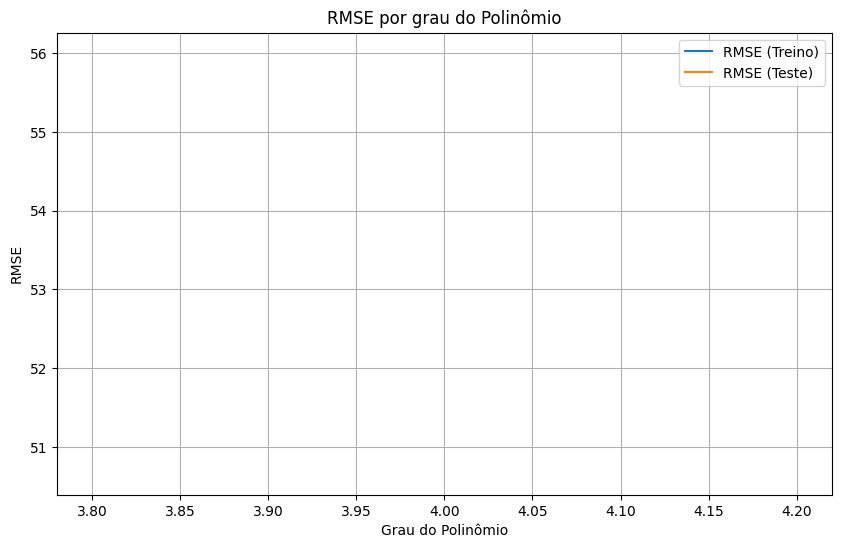

In [86]:
plt.figure(figsize=(10,6))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (Teste)')
plt.xlabel("Grau do Polinômio")
plt.ylabel("RMSE")
plt.title("RMSE por grau do Polinômio")
plt.legend()
plt.grid(True)
plt.show()

Para o gráfico funcionar, tirar do comentário o teste para ver qual polinomio é melhor (descomentar a parte graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### No gráfico abaixo, podemos ver que no 4 ele não possu uma diferença de treino e teste tão alta, então é o ideal se juntarmos os dois gráficos analisados.

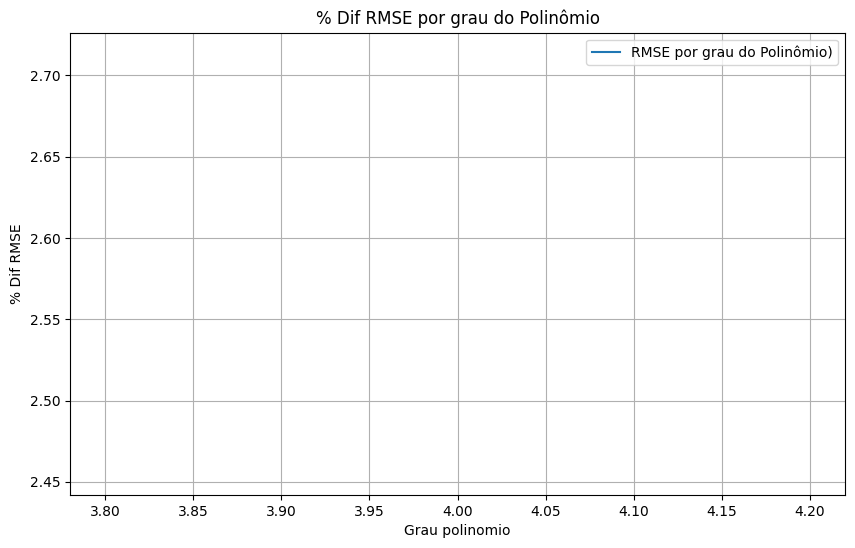

In [87]:
# Plotar Gráfico para comprar %Dif RMSE (Treino e Teste)
plt.figure(figsize=(10, 6))
plt.plot(graus_polynomial, percentual_rmse_values,
         label='RMSE por grau do Polinômio)')
plt.xlabel("Grau polinomio")
plt.ylabel("% Dif RMSE")
plt.title("% Dif RMSE por grau do Polinômio")
plt.legend()
plt.grid(True)
plt.show()

Para o gráfico funcionar, tirar do comentário o teste para ver qual polinomio é melhor (descomentar a parte graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### 5. Validação do Modelo - Regressão Polinomial



#### Análise de Métricas - Modelo Polinomial



Realizamos uma análise comparativa entre o modelo polinomial de grau 4 e o modelo linear. O modelo polinomial apresentou uma redução de aproximadamente 10% no RMSE, representando uma melhoria significativa em relação ao menor salário na base de dados. O R² aumentou para 0.9998, evidenciando um ajuste quase perfeito aos dados. Esses resultados confirmam que o modelo polinomial é superior ao modelo linear. A próxima etapa será analisar os resíduos para avaliar a consistência do ajuste.

In [88]:
# Métricas
print(f'RMSE Treino: R${rmse_train_final:.2f}')
print(f'RMSE Teste: R${rmse_test_final:.2f}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final:.4f}%')
print(f'R2Score Teste: {r2score_test_final:.4f}%')

RMSE Treino: R$53.33
RMSE Teste: R$54.71
% Dif. RMSE Treino e Teste: 2.5842%
R2Score Teste: 0.9999%


#### Análise de Resíduos - Modelo Polinomial



Analisamos os resíduos do modelo polinomial em comparação com o modelo linear. O modelo polinomial demonstrou melhorias notáveis em linearidade e homoscedasticidade. Além disso, os testes de distribuição normal, como Shapiro-Wilk e Kolmogorov-Smirnov, indicaram que os resíduos seguem uma distribuição normal, diferentemente do modelo linear. Esses resultados reforçam que o modelo polinomial, com suas features geradas, oferece métricas e análise de resíduos superiores. As próximas etapas incluem a realização de previsões individuais, o salvamento do modelo e a implementação em uma aplicação e API.


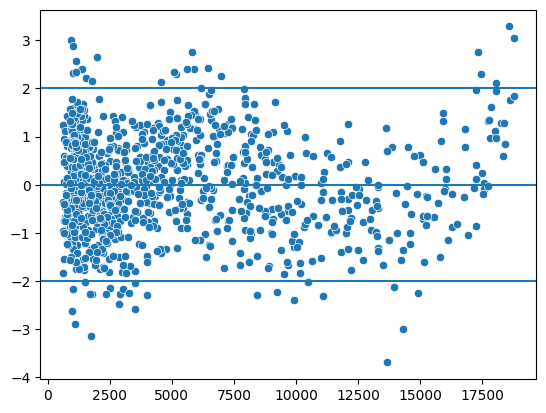

In [89]:
residuos_std = zscore(residuos)
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

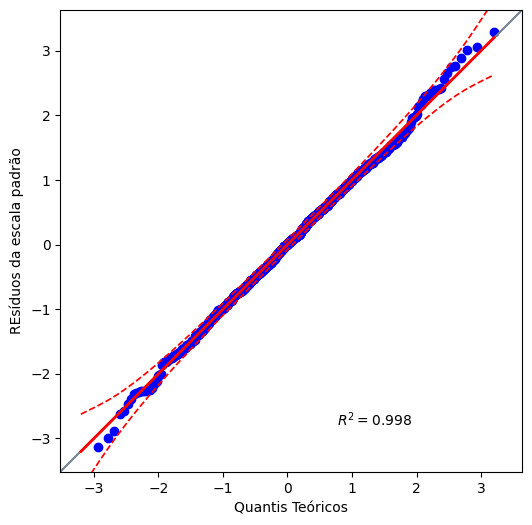

In [90]:
plt.figure(figsize=(12, 6))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel("Quantis Teóricos")
plt.ylabel("REsíduos da escala padrão")
plt.show()

In [91]:
# Teste de normalidade - Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat: teste = {stat_shapiro:.4f} e P-Value = {p_value_shapiro}')

# Como p value é maior que 0,05, não rejeitamos H0, ou seja, segue-se uma distribuição normal segundo o teste de Shapiro-Wilk

Estat: teste = 0.9987 e P-Value = 0.6852797159667293


In [92]:
# Teste de normalidade - Kolmogorov Smirnov
stats_ks, p_value_ks = kstest(residuos, "norm")
print(f"Estat: Teste = {stats_ks:.4f} e P-Value = {p_value_ks}")

# Como p value é menor que 0,05, rejeitamos H0, ou seja, não segue-se uma distribuição normal segundo o teste de Kolmogorov Smirnov

Estat: Teste = 0.4824 e P-Value = 1.220246010522094e-214


In [97]:
# Teste de Normalidade _ Lillefors
stat_ll, p_value_ll = lilliefors(residuos, dist="norm", pvalmethod="table")
print(f"Estat: Teste = {stat_ll:.4f} e P-Value = {p_value_ll}")

# Como p value é maior que 0,05, não rejeitamos H0, ou seja, segue-se uma distribuição normal segundo o teste de Lillefors


Estat: Teste = 0.0136 e P-Value = 0.9566270022048831


Concluímos que nosso modelo segue uma distribuição normal.

### 6. Realizar Predição



#### Realizar Predição Individual e Salvar Modelo



Analisamos a relevância do tempo de serviço e do nível da empresa na determinação do salário, identificando o tempo de serviço como a variável mais influente. Após concluir as análises gráficas, salvamos o modelo para uso futuro. Realizamos também uma predição individual, considerando uma pessoa com 6 anos de serviço e nível máximo na empresa, resultando em uma previsão salarial de R$ 4.880,31. Em seguida, nos preparamos para o deploy do modelo e sua entrega aos usuários.


In [100]:
input_features = {
    'tempo_na_empresa': 75,
    'nivel_na_empresa': 7,  
}


pred_df = pd.DataFrame(input_features, index=[1])

#predicao
model_poly.predict(pred_df)

array([5070.89968795])

In [101]:
# salvar modelo
joblib.dump(model_poly, "./modelo_salario.pkl")

['./modelo_salario.pkl']